# Imports

In [1]:
from PIL import Image, ImageDraw

Pytorch:

In [2]:
import torch
from torch import nn
import torchvision.transforms as transforms

Numpy and graphs:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
from datetime import timedelta
import sys
import random
from typing import List, Tuple

We will keep variables inside an object to avoid pulluting the global namespace and prevent various bugs. The defition below allows adding attributes at runtime:

In [4]:
class Object(object):
    pass

# We'll store all our variables here.
t = Object()

# Prepare - Generate Cylinder Images

Clean up previously generated images.

In [5]:
pm_kl_factor = 15

In [6]:
t.image_folder = f"images/_cylinders_{pm_kl_factor}"

In [7]:
!rm -rf images/_cylinders_{pm_kl_factor}
!mkdir -p output

The code below generates cylinder images that we will use for training. We don't use this code directly anywhere else. You can pre-generate images, save them, and use the training part separately.

In [8]:
class ImageContainer:
    def __init__(self, image: Image, wh: Tuple[int, int]):
        self.image = image
        self.wh = wh
        
    def save_to_dir(self, image_dir, image_index):
        w, h = self.wh
        save_path = f"{image_dir}/image_{w}_{h}_{image_index}.png"
        self.image.save(save_path, cmap="gray")
        
    def get_image(self) -> Image:
        return self.image

A function to draw images of cylinders:

In [9]:
def draw_cylinder(wh: tuple, image_size) -> ImageContainer: 
    w, h = wh
    background_color = 0
    figure_color = 200
    line_thickness = 2
    ellipse_h = 10 # int(min(image_size / 6, h / 3))
    im = Image.new("L", (image_size, image_size))
    
    draw = ImageDraw.Draw(im)
    draw.rectangle([0, 0, im.size[0], im.size[1]], 
                   fill=background_color,
                   outline=figure_color)
    
    # Calculate offsets when drawing a bounding rectangle
    im_w, im_h = im.size 
    x_offset = (im_w - w) / 2
    y_offset = (im_h - h) / 2

    # Sides
    draw.line([x_offset, y_offset, x_offset, y_offset + h], width=line_thickness, fill=figure_color)
    draw.line([x_offset + w, y_offset, x_offset + w, y_offset + h], width=line_thickness, fill=figure_color)
    
    
    # top ellipse
    draw.ellipse([
        x_offset, 
        y_offset - ellipse_h / 2,
        x_offset + w,
        y_offset + ellipse_h / 2], 
        width=line_thickness,
        outline=figure_color)
    
    # bottom ellipse
    draw.ellipse([
        x_offset, 
        y_offset - ellipse_h / 2 + h,
        x_offset + w,
        y_offset + ellipse_h / 2 + h], 
        width=line_thickness,
        outline=figure_color)
    
    # hide the back side of the bottom ellipse
    draw.rectangle([
        x_offset + line_thickness , 
        y_offset - ellipse_h / 2 + h,
        x_offset + w - line_thickness + 1,
        y_offset + h], 
        fill=background_color, 
        width=line_thickness)
    
    # TODO: fill with shade
    
    return ImageContainer(im, wh)
#------------------------------------------------------------------------------------
def generate_cylinders(count, w_range, h_range, image_size) -> List[ImageContainer]:
    images = []
    for w in range(w_range[0], w_range[1] + 1):
        for h in range(h_range[0], h_range[1] + 1):
            images.append(draw_cylinder((w, h), image_size))
    random.shuffle(images)
    return images[0:count]
#------------------------------------------------------------------------------------
def save_images(output_folder, images):
    print('Saving images to', output_folder)
    for i, img in enumerate(images):
        img.save_to_dir(output_folder, i)

Draw and save images of cylinders:

In [10]:
t.image_size = 64
t.size_range = (14, 50)
t.images = generate_cylinders(1000, t.size_range, t.size_range, t.image_size)
os.makedirs(t.image_folder, exist_ok=True)
save_images(t.image_folder, t.images)

Saving images to images/_cylinders_15


# Main part

## Create Device

We can run our code on GPU or CPU, if GPU is not present. Training will be very slow on CPU. However, when needed, we can pre-train our model on GPU, save, and then experiment with it on CPU. That'll be reasonably fast.

In [11]:
t.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t.device

device(type='cuda')

## To Tensor Transform

`ToTensor` is a function from the `transforms` package that converts numpy arrays to Pytorch Tensors. During the conversion it performs a few operations:

1. Changes order of dimensions from numpy's Height x Width x Channel to C x H x W.
2. Rescales [0, 255] to [0.0, 1.0]

In [12]:
t.to_tensor = transforms.ToTensor()

## Read Images

Location of our images (see the code above to find out this location):

In [13]:
def read_images(folder):
    print('Reading images from', folder)
    images = []
    image_tensors = []
    for fname in os.listdir(folder):
        image_path = f"{folder}/{fname}"
        im = Image.open(image_path).convert("L")
        np_im = np.asarray(im)
        images.append(np_im)
    return np.asarray(images)

In [14]:
t.images = read_images(t.image_folder)
t.images.shape

Reading images from images/_cylinders_15


(1000, 64, 64)

The function to display our images:

In [15]:
def plot_images(images):
    fig, axis = plt.subplots(1, len(images), figsize=(20, 5))
    for i, im in enumerate(images):
        ax = axis[i]
        ax.axis('off')
        ax.imshow(im, cmap="gray")

Let's see a small sample of the cylinders that we generated:

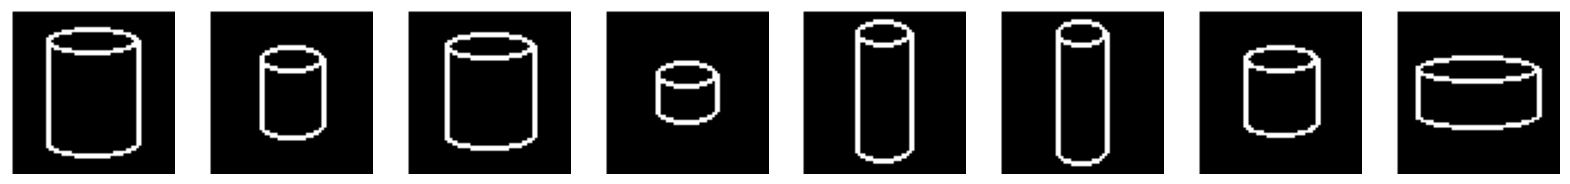

In [16]:
plot_images(t.images[210:218])

## Convert Images to Tensors

In [17]:
def image_np_to_tensor(images_np, to_tensor):
    count, w, h = images_np.shape
    images_t = torch.zeros(count, 1, h, w)
    for i in range(count):
        images_t[i] = to_tensor(images_np[i])
    return images_t

Remember, from the explanation above, ToTensor will add an extra array ([]) to signify the color channel even if the image is grayscale. Therefore, we'll see a dimension of '1':

In [18]:
t.images_t = image_np_to_tensor(t.images, t.to_tensor)
t.images_t.shape

torch.Size([1000, 1, 64, 64])

## Design Model

Pytorch doesn't provide a "reshape" layer that we will need for our model. They didn't provide "Flatten" for a while either, but then added it. The hope is they will add Reshape at some point as well.

For now, we'll just implement. All NN layers inherit from nn.Module.

In [19]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)

## Define Model

We now need to do extra steps during encoding, e.g. sampling from the normal distribution. So, we'll define our standard layers as `_encoder_main` and will have a function `encode` that will call layers, and do additional work.
    

In [20]:
class VAE(nn.Module):
    def __init__(self, device):
        super().__init__()
        
        self._total_epochs = 0
        self._training_time_s = 0
        self._timer = None
        self._mu = None
        self._log_var = None
        self.N = torch.distributions.Normal(0, 1)
        
        if device.type == 'cuda':
            self.N.loc = self.N.loc.cuda()
            self.N.scale = self.N.scale.cuda()
        
        self._encoder_main = nn.Sequential(
            # 64 x 64
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # 16 x 16
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # 8 x 8
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
        ).to(device)
                        
        self.decoder = nn.Sequential(
            nn.Linear(2, 64 * 4 * 4),
            Reshape(-1, 64, 4, 4),
            # 4 x 4
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 8 x 8 
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 16 x 16
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 32 x 32
            
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  
            nn.Sigmoid(),
            # 64 x 64
        ).to(device)
        
        self._mu_layer = nn.Linear(64 * 4 * 4, 2).to(device)
        self._log_var_layer = nn.Linear(64 * 4 * 4, 2).to(device)


    def encode(self, x):
        temp = self._encoder_main(x)
        self._mu = self._mu_layer(temp)
        self._log_var = self._log_var_layer(temp)
        std = torch.exp(0.5*self._log_var)
        eps = self.N.sample(self._mu.shape)
        encoded = self._mu + (eps * std)
        return encoded
        
    def forward(self, x):
        encoded = self.encode(x)
        return self.decoder(encoded)

    def start_training(self):
        if not self._timer:
            self._timer = timeit.default_timer()

    def end_training(self):
        self._training_time_s += timeit.default_timer() - self._timer
        self._timer = None

    def add_epochs(self, epochs):
        self._total_epochs += epochs
        
    def training_timedelta(self):
        return timedelta(seconds=self._training_time_s)
        
t.model = VAE(t.device)

In [21]:
print('Parameters: ', sum(p.numel() for p in t.model.parameters()))

Parameters:  141861


In [22]:
t.model.encode(t.images_t[0:1].to(t.device))

tensor([[ 0.3286, -2.6570]], device='cuda:0', grad_fn=<AddBackward0>)

## Analyze output images before training

### Inputs

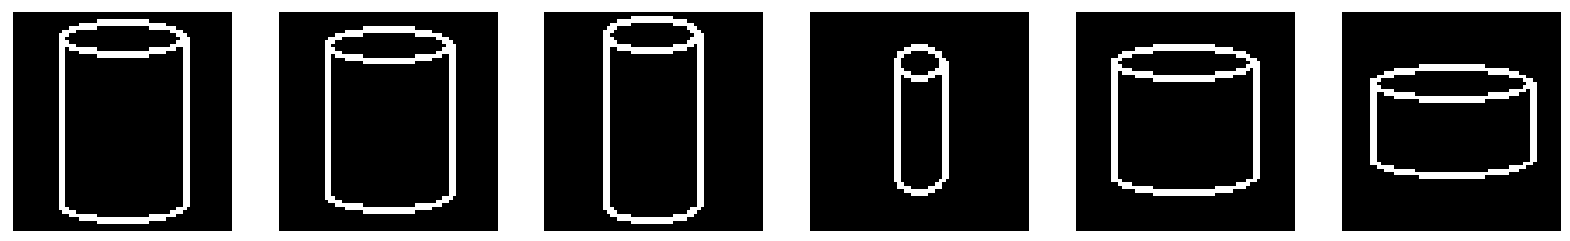

In [23]:
t.i = 100
plot_images(t.images[t.i:t.i+6])

What would output, that is, decoded images will look like now, before we did no training of the network? Let's pass images through the network, that is, execute the sequence:

    Input Image -> Encoder -> (0.1, -2.3) -> Decoder -> Output Image
    
Let's run the end-to-end model, both encoder and decoder:

In [24]:
t.sample_output = t.model(t.images_t[t.i : t.i+6].to(t.device))

What is the output?

In [25]:
t.sample_output.shape

torch.Size([6, 1, 64, 64])

Display output images

In [26]:
# Move images to CPU
t.imgs = t.sample_output.cpu()

# Disconnect from training data structures, 
# or Pytorch will complain during the conversion to numpy
t.imgs = t.imgs.detach()

# Conver to Numpy
t.imgs = t.imgs.numpy()

t.imgs.shape

(6, 1, 64, 64)

We need to get rid of an extra dimension, "1". Pytorch requires, but our drawing functions won't work:

In [27]:
t.imgs = np.squeeze(t.imgs)
t.imgs.shape

(6, 64, 64)

What should we expectt as an output image right now, before we trained the network at all? Run the following line to see if it's what you guessed.

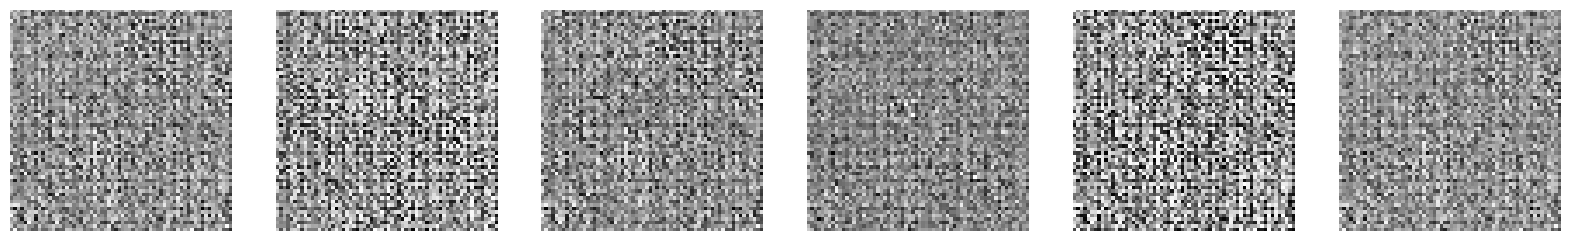

In [28]:
plot_images(t.imgs)

# Training Loop

## Loss functions

We need two loss functions:
1. Reconstruction loss, i.e. how much the output images differs from the original, an image of a cylinder. Obviously, the images we see above differ quite a lot, so the loss will be high. As we train the network, it will output more cylinder-like images, and the loss will decline.

2. The second  loss is how far the distribution of the embeddings differs form the Standard Normal distribution. Standard Normal distribution has the mean of '0' and standard deviation of '1'. In other words, we want encoder to keep the embeddings close to the (0, 0) and be generally simmetrical.

## Embedding Distribution Before Training

We saw what images look like before any training took place. Let's take a look at what the distribution of embreddings looks like.

Let's pass all images through just the encoder:

In [29]:
t.model.eval()
with torch.no_grad():
    t.emb_t = t.model.encode(t.images_t.to(t.device))

# Move results to CPU
t.emb = t.emb_t.cpu().detach().numpy();

t.emb.shape

(1000, 2)

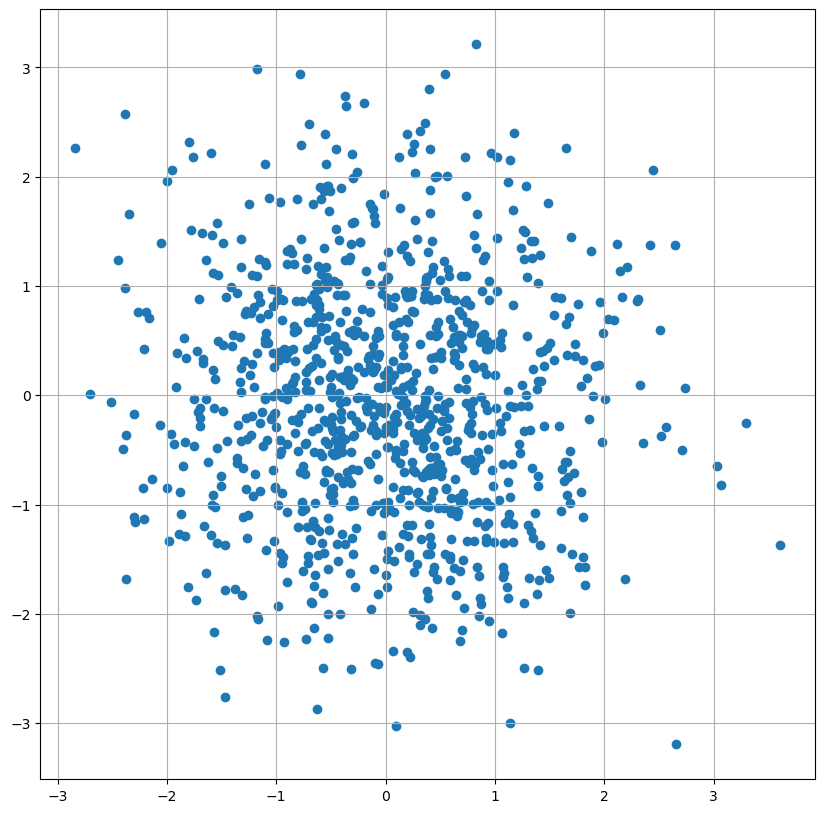

In [30]:
plt.figure(figsize=(10, 10))
plt.grid()
_ = plt.scatter(t.emb[:, 0], t.emb[:, 1])

## Implement Loss Functions

### Reconstruction loss
MSE, or mean-squared error. Subtracts pixel of the two images, squares and averages them. If the images are the same the loss will be exactly zero.

In [31]:
# def mse_loss(pred, y_true):
#     return ((pred - y_true)**2).mean()
t.mse_loss_base = nn.MSELoss(reduction="none")

def mse_loss(pred, y_true):
    pixel_loss = t.mse_loss_base(pred, y_true)
    batch_size = y_true.shape[0]
    pixel_loss_sum = pixel_loss.view(batch_size, -1).sum(axis=1) # Sum over pixels
    loss = pixel_loss_sum.mean() # mean over the batch
    return loss

## Distribution difference
Kullback->Leibler Divergence.

In [32]:
def kl_loss(pred, y_true):
    mu = t.model._mu
    log_var = t.model._log_var
    var = torch.exp(log_var)
    kl_loss_sum = -0.5 * (1 + log_var - mu**2 - var).sum(axis=1) # some over dims
    kl_loss = kl_loss_sum.mean() # mean over batch
    return kl_loss

#### Overall Loss
Combines both losses:

In [33]:
def vae_loss(pred, y_true):
    r_loss = mse_loss(pred, y_true)
    kl_div = kl_loss(pred, y_true)
    return r_loss + pm_kl_factor * kl_div

In [34]:
t.criterion = vae_loss

## Training Loop

In [35]:
def train(model, n_epochs, train_images, opt, criterion, report_each_nth_epoch):
    batch_size = 32
    print("Batch size:", batch_size)
    print("KL factor:", pm_kl_factor)
    print(f"Epoch, Train loss, Valid loss, MSE Loss, KL Loss, Total epochs, Total train time")
    for epoch in range(1, n_epochs + 1):
        model.start_training()
        batch_count = int(train_images.shape[0] / batch_size) + 1
        for i in range(0, batch_count):
            start_i = i * batch_size
            image_batch = train_images[start_i : start_i + batch_size].to(t.device)
            if image_batch.shape[0] > 0:
                
                output = model(image_batch)
                
                loss = criterion(output, image_batch)
                                
                model.zero_grad()
                
                loss.backward()
                
                opt.step()
        model.add_epochs(1)
        if epoch % report_each_nth_epoch == 0:
            model.end_training()
            model.eval()
            with torch.no_grad():
                eval_images = train_images[:256].to(t.device)
                output = model(eval_images)
                valid_loss = criterion(output, eval_images).item()
                r_loss = mse_loss(output, eval_images).item()
                mu_loss = kl_loss(output, eval_images).item()
                print(f"{epoch}, {loss.item():.2f}, {valid_loss:.2f}, {r_loss:.2f},",
                      f"{mu_loss :.5f}, {model._total_epochs}, {model.training_timedelta()}")
            model.train()

### Optimizer
Optimizer is an algorithm that trains the network. All of them are a version of a stochastic gradient descent. We will use Adam, with a learning rate of `1e-4`.

The learning rate is determined experimentally, but usually around `1e-3` to `1e-4`. There are advanced techniques to set the learning rate more precisely, but we don't need them here.

In [36]:
t.opt = torch.optim.Adam(t.model.parameters(), lr=1e-4)

## Run Training

You might want to get some coffee after you run the next line.

In [37]:
train(
    model=t.model, 
    n_epochs=3000, 
    train_images=t.images_t, 
    opt=t.opt, 
    criterion=t.criterion, 
    report_each_nth_epoch=50)

Batch size: 32
KL factor: 15
Epoch, Train loss, Valid loss, MSE Loss, KL Loss, Total epochs, Total train time
50, 157.51, 170.04, 168.35, 0.11271, 50, 0:00:24.228063
100, 173.74, 185.27, 185.14, 0.00855, 100, 0:00:49.104470
150, 157.12, 169.27, 169.03, 0.01638, 150, 0:01:14.142651
200, 152.04, 168.63, 165.22, 0.22719, 200, 0:01:39.076887
250, 155.43, 166.54, 161.48, 0.33774, 250, 0:02:03.998580
300, 151.37, 167.08, 160.21, 0.45796, 300, 0:02:29.018856
350, 154.24, 166.30, 156.44, 0.65728, 350, 0:02:54.142260
400, 150.63, 164.28, 149.42, 0.99073, 400, 0:03:19.080813
450, 159.78, 161.04, 142.06, 1.26546, 450, 0:03:44.006924
500, 143.47, 159.08, 133.95, 1.67531, 500, 0:04:09.011677
550, 142.27, 155.47, 121.24, 2.28226, 550, 0:04:33.901418
600, 138.63, 147.17, 101.68, 3.03246, 600, 0:04:58.785835
650, 138.85, 144.96, 94.20, 3.38418, 650, 0:05:23.613813
700, 136.10, 141.54, 85.35, 3.74552, 700, 0:05:48.665320
750, 133.78, 135.68, 76.71, 3.93175, 750, 0:06:13.794981
800, 119.50, 137.00, 75.7

# Save the Model

In [38]:
torch.save(t.model, f"output/cylinder_vae.{pm_kl_factor}.pkl")

# (Re-)Load Model

Let's create a new object where we will keep the loaded model, and all related data.

In [39]:
a = Object()

## Use Current Session

Uncomment the next line if you want to use the model you trained right now:

In [40]:
a.model = t.model

## Use Previously Loaded Model

In [41]:
# a.model = torch.load('../input/cylinder-vae/cylinder_vae.pkl', map_location=t.device)

## Generate embeddings by running Encoder

In [42]:
a.model.eval()
with torch.no_grad():
    a.emb_t = a.model.encode(t.images_t.to(t.device))
a.emb = a.emb_t.cpu().detach().numpy()
a.emb.shape

(1000, 2)

# Analyze the Autoencoder
Pass all images through the Encoder, and plot the points in teh 2-D latent space.

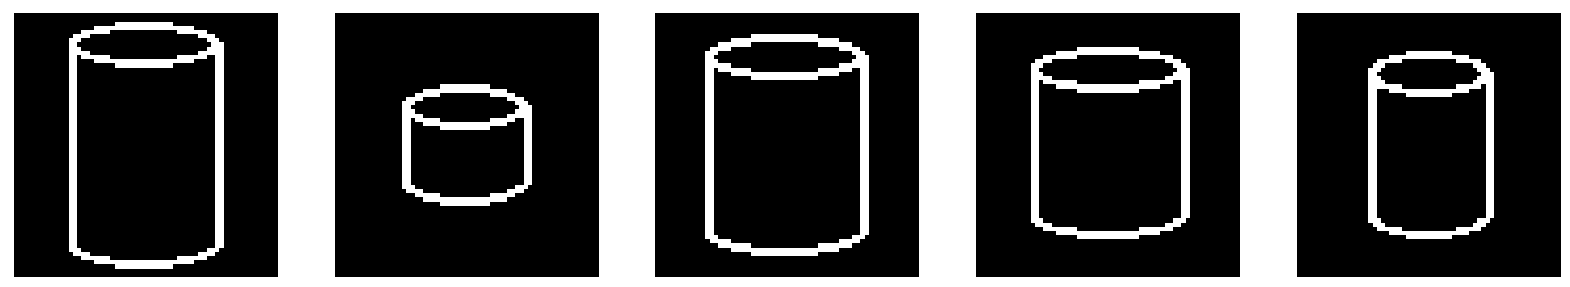

In [43]:
i = 10
plot_images(t.images[i:i+5])

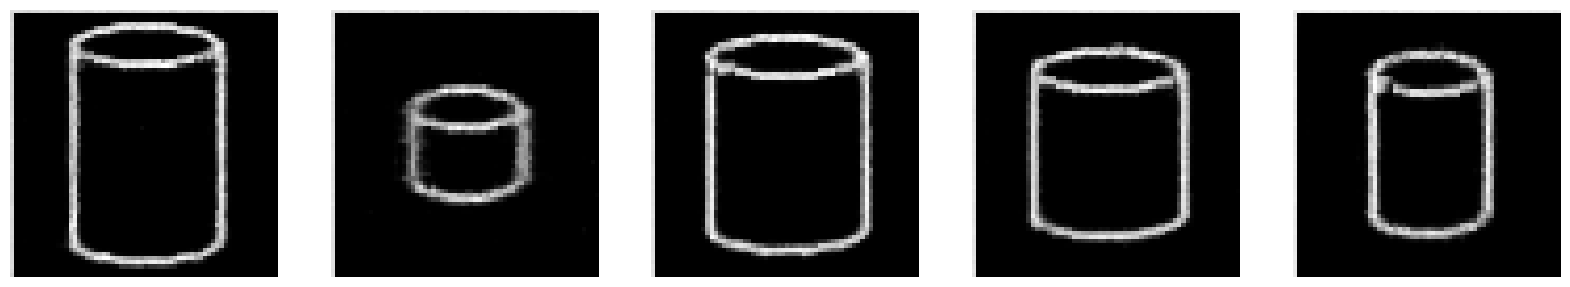

In [44]:
imgs = a.model(t.images_t[i: i+ 5].to(t.device))
plot_images(np.squeeze(imgs.detach().cpu().numpy()))

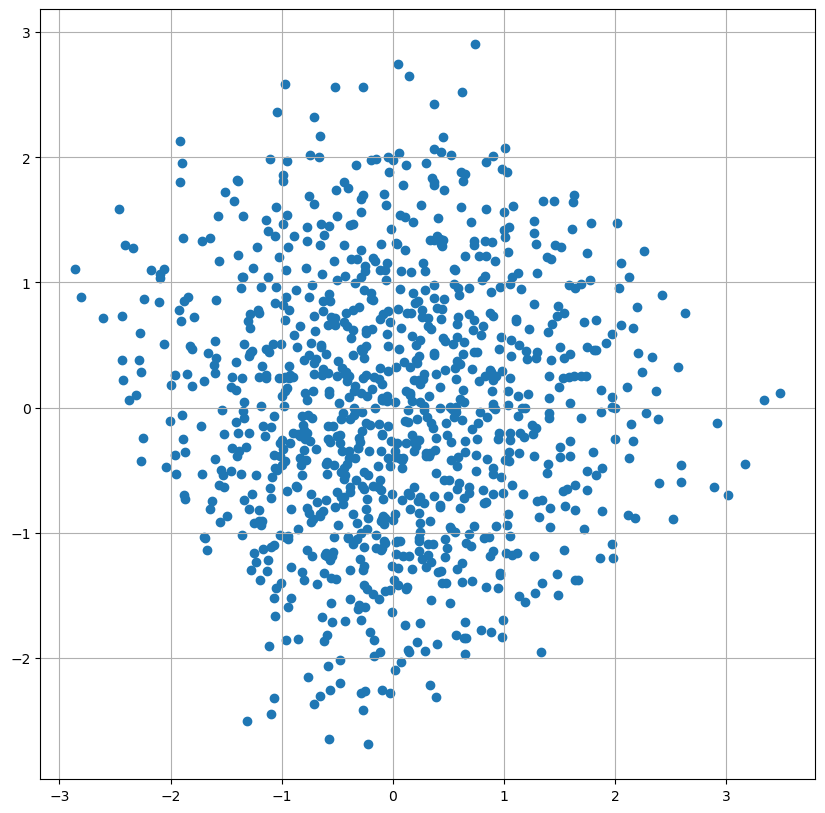

In [45]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(a.emb[:,0], a.emb[:,1])

In [46]:
def dream_cylinder(x, y, model):
    plt.imshow(
        model.decoder(torch.tensor([x*1.0, y]).to(t.device)).detach().cpu().numpy()[0][0],
        cmap="gray")

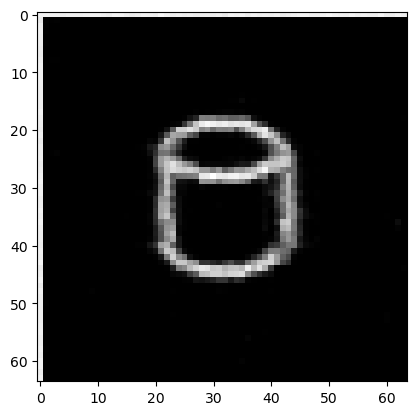

In [47]:
dream_cylinder(-1.3, -0.3, a.model)

# Plot Reconstruction Space

We will plot the space of embedding and display cylinders corresponding to each point.

In [48]:
def plot_embedding_space(
    model: VAE,
    x_range: Tuple[int], 
    y_range: Tuple[int], 
    wh: Tuple[int], 
    n: int):
    w = wh[0]
    big_img = np.zeros((w * n, w * n))
    xs = np.linspace(x_range[0], x_range[1], n)
    ys = np.linspace(y_range[0], y_range[1], n)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            z = torch.Tensor([[x, y]]).to(t.device)
            input_hat = model.decoder(z) \
                .reshape(w, w) \
                .to('cpu') \
                .detach() \
                .numpy()
            big_img[(n - 1 - i) * w : (n - 1 - i + 1) * w,
                j * w : (j + 1) * w] = input_hat
    plt.figure(figsize=(15, 15))
    plt.imshow(big_img, extent=[*x_range, *y_range], cmap="gray")

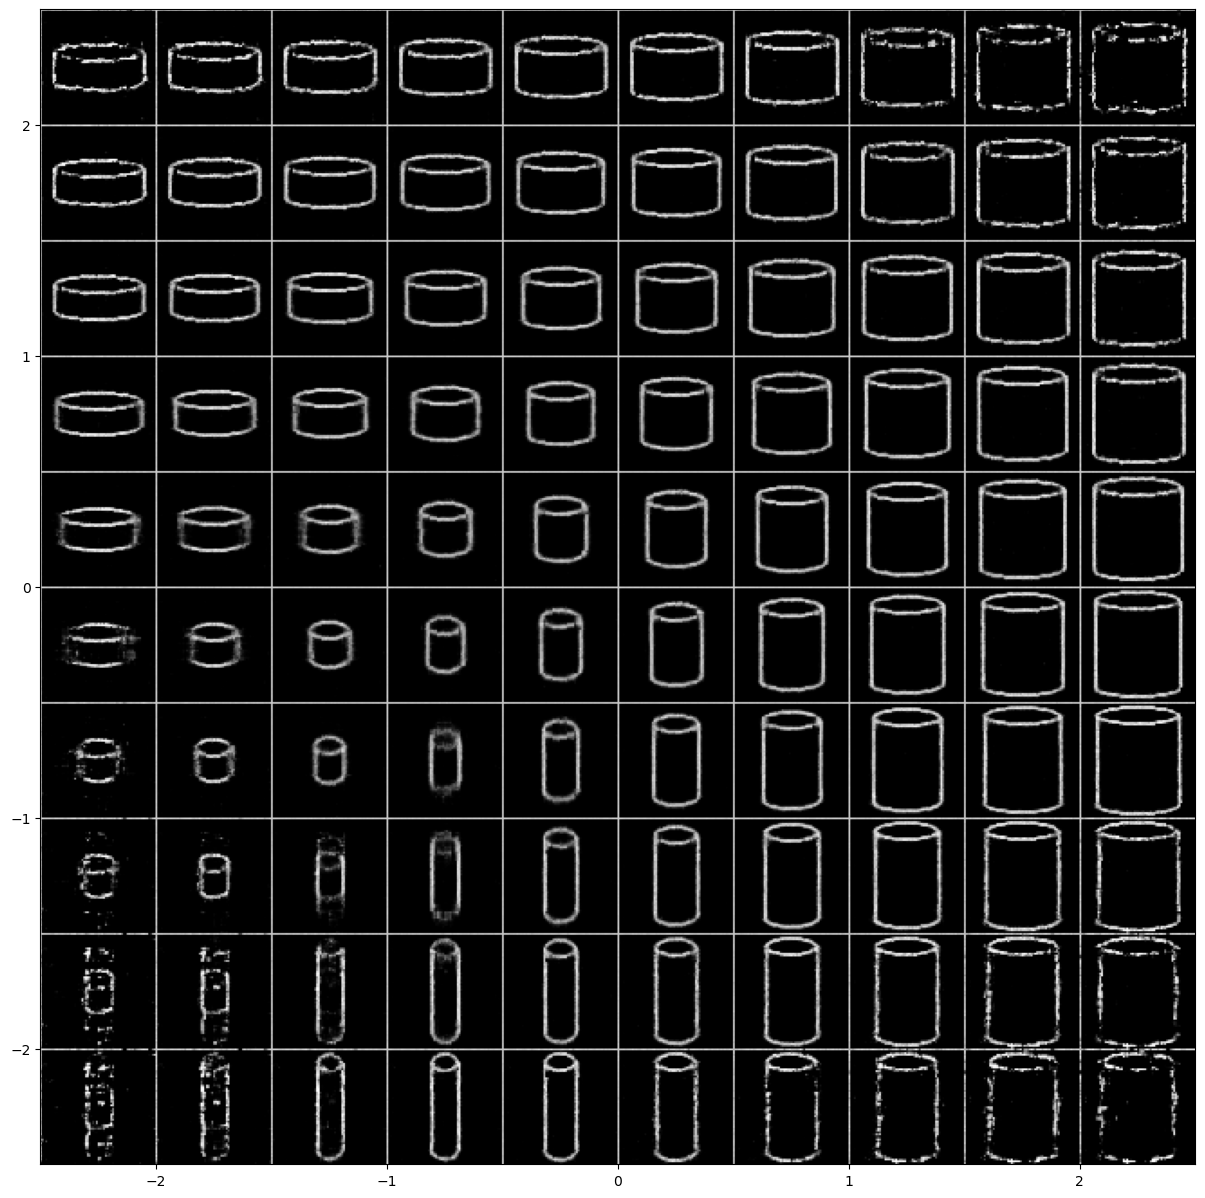

In [49]:
t.x_range = (a.emb[:,0].min(), a.emb[:,0].max())
t.y_range = (a.emb[:,1].min(), a.emb[:,1].max())

plot_embedding_space(a.model, 
                     x_range=(-2.5, 2.5), 
                     y_range=(-2.5, 2.5), 
                     wh=(64, 64),
                     n=10)

# Latent Space Vector Algebra

1. Find all narrow cylinders, calculate their average embedding.
2. Find all wide cylinders, calculate thrir average embedding.
3. Subtract (2) from from (1). We will get obtain a vector that points in the direction of "widening". Then we can add it to any cylider and make it wider. 

In [50]:
# Class to parse cylinder sizes

class ImageContainer:
    def __init__(self, file_path):
        self._file_path = file_path
        self.image_np = np.asarray(Image.open(file_path).convert("L"))
        parts = os.path.basename(file_path).split('_') # image, 105 (width), 20 (height), 33.png
        self.w = int(parts[1])
        self.h = int(parts[2])

In [51]:
# 1. Read all cylinder files, 
# 2. Select all narrowest ones
# 3. Select all widest ones
# 4. Calculate all embeddings.
# 5. Subract.

In [52]:
def read_parse_images(folder) -> List[ImageContainer]:
    images = []
    for fname in os.listdir(folder):
        image_path = f"{folder}/{fname}"
        img_container = ImageContainer(image_path)
        images.append(img_container)
    return images

In [53]:
a.parsed_images = read_parse_images(t.image_folder)

In [54]:
def select_images(images: List[ImageContainer]) -> Tuple:
    narrow = []
    wide = []
    for im in images:
        if im.w < 18:
            narrow.append(im.image_np)
        if im.w > 48:
            wide.append(im.image_np)
    narrow = np.asarray(narrow)
    wide = np.asarray(wide)
    return narrow, wide

In [55]:
a.narrow_np, a.wide_np = select_images(a.parsed_images)
a.narrow_np.shape, a.wide_np.shape

((101, 64, 64), (55, 64, 64))

In [56]:
a.narrow_t = image_np_to_tensor(a.narrow_np, t.to_tensor).to(t.device)
a.wide_t = image_np_to_tensor(a.wide_np, t.to_tensor).to(t.device)

In [57]:
a.narrow_emb = a.model.encode(a.narrow_t)
a.wide_emb = a.model.encode(a.wide_t)

In [58]:
a.wider_vector = torch.mean(a.wide_emb, axis=0) - torch.mean(a.narrow_emb, axis=0)
a.wider_vector

tensor([1.3722, 2.9061], device='cuda:0', grad_fn=<SubBackward0>)

## Convert Narrow Cylinder to Wide

Let's select a couple of narrow cylinders, using numpy format first:

In [59]:
a.narrow_images = []
for a.narrow_im in a.parsed_images:
    if a.narrow_im.w <= 16:
        a.narrow_images.append(a.narrow_im.image_np)
    if len(a.narrow_images) >= 2:
        break
        
assert len(a.narrow_images) >= 2

Convert images to tensors:

In [60]:
a.narrow_images_t = image_np_to_tensor(np.asarray(a.narrow_images), t.to_tensor)

Plot narrow images:

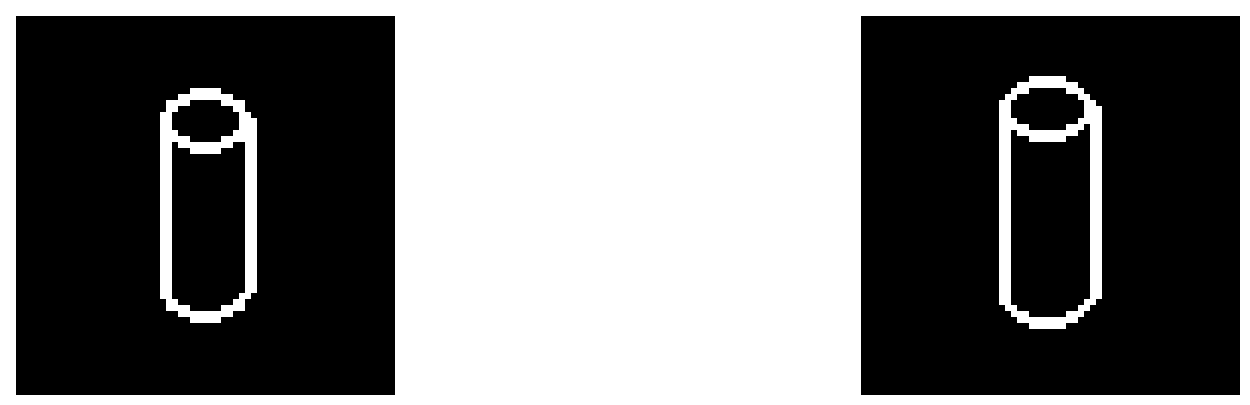

In [61]:
plot_images(a.narrow_images)

Convert narrow images to wide images:

1. Generated embeddings for narrow images using the encoder.
2. Add "make wider" vector. We can scale this vector by a factor [0..1] to make the cylinder slighly wider, or much wider. 
   1. We'll scale by 0.6
3. Convert the resulting embeddings back to images using the decoder.

In [62]:
# 1
a.narrow_encoded = a.model.encode(a.narrow_images_t.to(t.device))

In [63]:
# 2
a.wider_encoded = a.narrow_encoded + a.wider_vector * 0.6

In [64]:
# 3
a.wider_images = a.model.decoder(a.wider_encoded)

Display wider images:

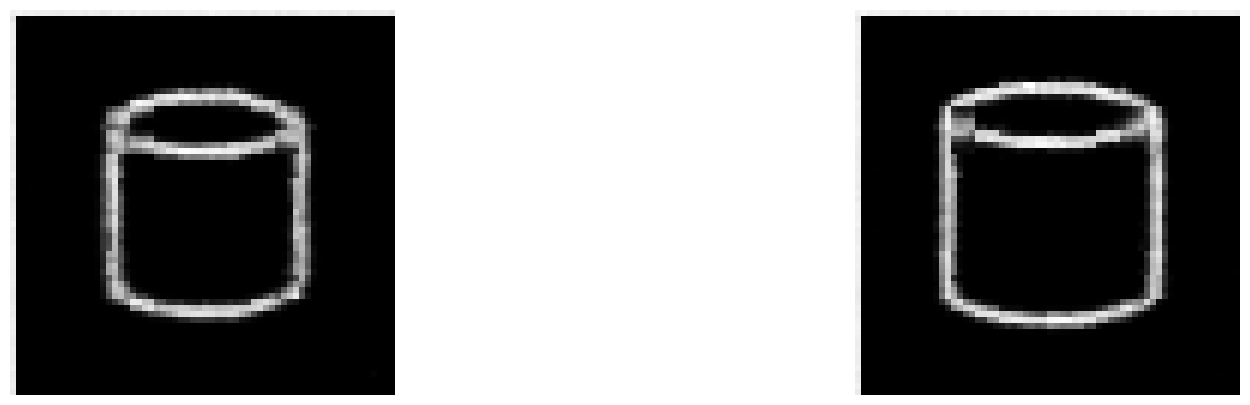

In [65]:
plot_images(np.squeeze(a.wider_images.cpu().detach().numpy()))